In [1]:
import argparse
import logging

import numpy as np
from anndata import read_h5ad
from PIL import Image
from scipy import ndimage
from skimage.color import rgb2hsv, rgb2gray
from skimage.exposure import equalize_adapthist
from skimage.filters import gaussian, threshold_otsu
from skimage.transform import SimilarityTransform, estimate_transform, rotate, rescale
from threadpoolctl import threadpool_limits

from openst.alignment import feature_matching, fiducial_detection
from openst.metadata.classes.pairwise_alignment import (AlignmentResult,
                                       PairwiseAlignmentMetadata)
from openst.utils.file import (check_adata_structure, check_directory_exists,
                               check_file_exists, load_properties_from_adata,
                               save_pickle)
from openst.utils.pseudoimage import create_pseudoimage

In [2]:
from openst.alignment.pairwise_aligner import prepare_image_for_feature_matching, prepare_pseudoimage_for_feature_matching, apply_transform, transform_image, get_pairwise_aligner_parser

In [3]:
parser = get_pairwise_aligner_parser()

In [6]:
args = parser.parse_args([
    '--image-in', '/data/rajewsky/home/dleonpe/projects/openst_paper/data/1_images_ln/stitched/fc_sts_63_7/Image_Stitched_Composite.tif',
    '--h5-in', '/data/rajewsky/home/dleonpe/projects/openst_paper/data/2_downstream/fc_sts_63/stitched/fc_sts_063_7_stitched_spots.h5ad',
    '--h5-out', '/data/rajewsky/home/dleonpe/projects/openst_paper/data/2_downstream/fc_sts_63/auto_aligned_he/fc_sts_063_7_stitched_spots_aligned.h5ad',
    '--save-image-in-h5',
    '--feature-matcher', 'LoFTR',
    '--ransac-coarse-max-trials', '50',
    '--ransac-fine-max-trials', '50',
    '--n-threads', '8',
    '--ransac-coarse-residual-threshold', '2',
    '--ransac-coarse-min-samples', '2',
    '--metadata-out', '/data/rajewsky/home/dleonpe/projects/openst_paper/data/2_downstream/fc_sts_63/auto_aligned_he/fc_sts_063_7_alignment_metadata.json',
    '--threshold-counts-coarse', '5',
    '--mask-tissue',
    '--keep-black-background',
    #'--fiducial-model', '/data/rajewsky/home/dleonpe/projects/openst_paper/repos/openst/models/yolov8s_fiducial_detection_universal.pt'
])

In [7]:
print("open-ST pairwise alignment; running with parameters:")
print(args.__dict__)

# Check input and output data
check_file_exists(args.h5_in)
check_adata_structure(args.h5_in)
check_file_exists(args.image_in)

if not check_directory_exists(args.h5_out):
    raise FileNotFoundError("Parent directory for --h5-out does not exist")

if args.metadata_out != "" and not check_directory_exists(args.metadata_out):
    raise FileNotFoundError("Parent directory for the metadata does not exist")

if args.h5_out == args.h5_in:
    raise ValueError("The path to the output file cannot be the same as the input file")

# Set maximum image size to support large HE
Image.MAX_IMAGE_PIXELS = args.max_image_pixels

# Loading the spatial transcriptomics data
sts = load_properties_from_adata(args.h5_in, properties=["obsm/spatial", "obs/total_counts", "obs/puck_id", "X", 'var'])

# Loading image data
staining_image = np.array(Image.open(args.image_in))

in_coords = sts["obsm/spatial"]
total_counts = sts["obs/total_counts"]
puck_id = sts["obs/puck_id"]
staining_image = staining_image
gene_names = sts['var'].index.values
genes_X_sparse = sts["X"]


gene_idx_mask = np.isin(gene_names, ['MALAT1', 'MT-CO2', 'MT-CYTB'])
genes_X_sparse_selected = genes_X_sparse[:, gene_idx_mask].sum(axis=1)

genes_selected_coarse = None
genes_selected_fine = np.array(genes_X_sparse_selected).flatten()

open-ST pairwise alignment; running with parameters:
{'image_in': '/data/rajewsky/home/dleonpe/projects/openst_paper/data/1_images_ln/stitched/fc_sts_63_7/Image_Stitched_Composite.tif', 'h5_in': '/data/rajewsky/home/dleonpe/projects/openst_paper/data/2_downstream/fc_sts_63/stitched/fc_sts_063_7_stitched_spots.h5ad', 'metadata_out': '/data/rajewsky/home/dleonpe/projects/openst_paper/data/2_downstream/fc_sts_63/auto_aligned_he/fc_sts_063_7_alignment_metadata.json', 'h5_out': '/data/rajewsky/home/dleonpe/projects/openst_paper/data/2_downstream/fc_sts_63/auto_aligned_he/fc_sts_063_7_stitched_spots_aligned.h5ad', 'save_image_in_h5': True, 'mask_tissue': False, 'only_coarse': False, 'rescale_factor_coarse': 20, 'rescale_factor_fine': 5, 'tissue_masking_gaussian_sigma': 5, 'fine_registration_gaussian_sigma': 2, 'keep_black_background': False, 'threshold_counts_coarse': 5, 'threshold_counts_fine': 0, 'pseudoimage_size_coarse': 4000, 'pseudoimage_size_fine': 6000, 'ransac_coarse_min_samples': 2

In [8]:
import matplotlib.pyplot as plt
from skimage.transform import warp
from itertools import product

In [9]:
args.mask_tissue = True
args.keep_black_background = True

In [10]:
# Create output objects
out_coords_output_fine = np.zeros_like(in_coords)
metadata = PairwiseAlignmentMetadata(args)

print(f"Coarse registration, {len(in_coords)} coordinates")

# Preparing images and preprocessing routines
# staining_image_rescaled = staining_image[:: args.rescale_factor_coarse, :: args.rescale_factor_coarse]
blur_antialias = int((args.rescale_factor_coarse - 1)/2)
#src = cv2.resize(cv2.GaussianBlur(staining_image,(blur_antialias, blur_antialias),0), (0,0), fx=1/args.rescale_factor_coarse, fy=1/args.rescale_factor_coarse, interpolation=cv2.INTER_NEAREST) 
staining_image_rescaled = rescale(staining_image, 1/args.rescale_factor_coarse, preserve_range=True, anti_aliasing=True, channel_axis=-1).astype(np.uint8)
src = staining_image_rescaled

def src_augmenter(x, flip, rotation):
    return prepare_image_for_feature_matching(
        image=x,
        flip=flip,
        rotation=rotation,
        mask_tissue=args.mask_tissue,
        keep_black_background=args.keep_black_background,
        mask_gaussian_blur=args.tissue_masking_gaussian_sigma,
    )

sts_coords = in_coords[total_counts > args.threshold_counts_coarse]
sts_pseudoimage = create_pseudoimage(sts_coords, args.pseudoimage_size_coarse, staining_image_rescaled.shape)
dst = prepare_pseudoimage_for_feature_matching(sts_pseudoimage['pseudoimage'])

# Feature matching
in_mkpts0, in_mkpts1, _best_flip, _best_rotation = feature_matching.match_images(
    src,
    dst,
    feature_matcher=args.feature_matcher,
    src_augmenter=src_augmenter,
    ransac_min_samples=args.ransac_coarse_min_samples,
    ransac_residual_threshold=args.ransac_coarse_residual_threshold,
    ransac_max_trials=args.ransac_coarse_max_trials,
    device='cuda'
)

# Estimate and apply transform
tform_points = estimate_transform("similarity", in_mkpts0, in_mkpts1)
sts_coords_to_transform = sts_pseudoimage["coords_rescaled"] * sts_pseudoimage["rescaling_factor"]
sts_coords_transformed = apply_transform(sts_coords_to_transform, tform_points, check_bounds=False)
sts_coords_transformed = sts_coords_transformed * args.rescale_factor_coarse

# Remove coordinates outside the image (for pseudoimage generation)
_i_sts_coords_coarse_within_image_bounds = np.where(
    (sts_coords_transformed[:, 0] > 0)
    & (sts_coords_transformed[:, 0] < staining_image.shape[1])
    & (sts_coords_transformed[:, 1] > 0)
    & (sts_coords_transformed[:, 1] < staining_image.shape[0])
)
sts_coords_transformed = sts_coords_transformed[_i_sts_coords_coarse_within_image_bounds][:, :-1]

# Apply transform to all coordinates & retransform back
sts_coords_coarse = in_coords.copy()
sts_coords_coarse -= sts_pseudoimage["offset_factor"]
sts_coords_coarse = (
    (sts_coords_coarse / sts_pseudoimage["rescale_factor"]) * sts_pseudoimage["scale"]
) * sts_pseudoimage["rescaling_factor"]

sts_coords_coarse = apply_transform(sts_coords_coarse, tform_points, check_bounds=False)
sts_coords_coarse = sts_coords_coarse * args.rescale_factor_coarse
sts_coords_coarse = sts_coords_coarse[:, :-1]
out_coords_output_coarse = sts_coords_coarse.copy()

# Saving alignment results here
_align_result = AlignmentResult(
    name="coarse_alignment_whole_section",
    im_0=transform_image(src, _best_flip, [0, None, 0, None], _best_rotation),
    im_1=sts_pseudoimage["pseudoimage"],
    transformation_matrix=tform_points.params,
    ransac_results=None,
    sift_results=None,
    keypoints0=in_mkpts0,
    keypoints1=in_mkpts1,
)
metadata.add_alignment_result(_align_result)

Coarse registration, 18156586 coordinates


/home/dleonpe/miniconda3/envs/openst_dev/lib/python3.10/site-packages/skimage/util/dtype.py:492: UserWarning: Downcasting int64 to uint16 without scaling because max value 255 fits in uint16
  return _convert(image, np.uint16, force_copy)
/home/dleonpe/miniconda3/envs/openst_dev/lib/python3.10/site-packages/skimage/util/dtype.py:492: UserWarning: Downcasting int64 to uint16 without scaling because max value 164 fits in uint16
  return _convert(image, np.uint16, force_copy)
/home/dleonpe/miniconda3/envs/openst_dev/lib/python3.10/site-packages/skimage/util/dtype.py:492: UserWarning: Downcasting int64 to uint16 without scaling because max value 0 fits in uint16
  return _convert(image, np.uint16, force_copy)
/home/dleonpe/miniconda3/envs/openst_dev/lib/python3.10/site-packages/skimage/util/dtype.py:492: UserWarning: Downcasting int64 to uint16 without scaling because max value 250 fits in uint16
  return _convert(image, np.uint16, force_copy)
/home/dleonpe/miniconda3/envs/openst_dev/lib/p

In [ ]:
# Saving alignment results here
_align_result = AlignmentResult(
    name="coarse_alignment_whole_section",
    im_0=transform_image(src, _best_flip, [0, None, 0, None], _best_rotation),
    im_1=sts_pseudoimage["pseudoimage"],
    transformation_matrix=tform_points.params,
    ransac_results=None,
    sift_results=None,
    keypoints0=in_mkpts0,
    keypoints1=in_mkpts1,
)
metadata.add_alignment_result(_align_result)

In [11]:
_best_flip, _best_rotation

([-1, -1], 90)

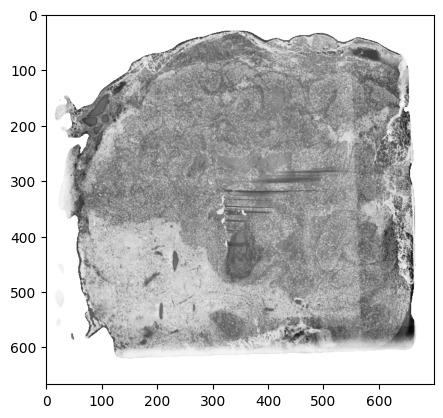

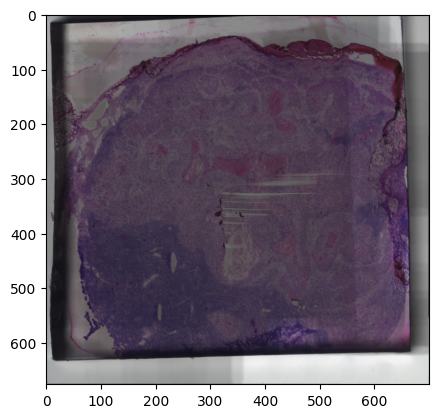

In [12]:
plt.imshow(src_augmenter(src, [1, 1], 0)[4], cmap='Greys')
plt.show()
plt.imshow(src)

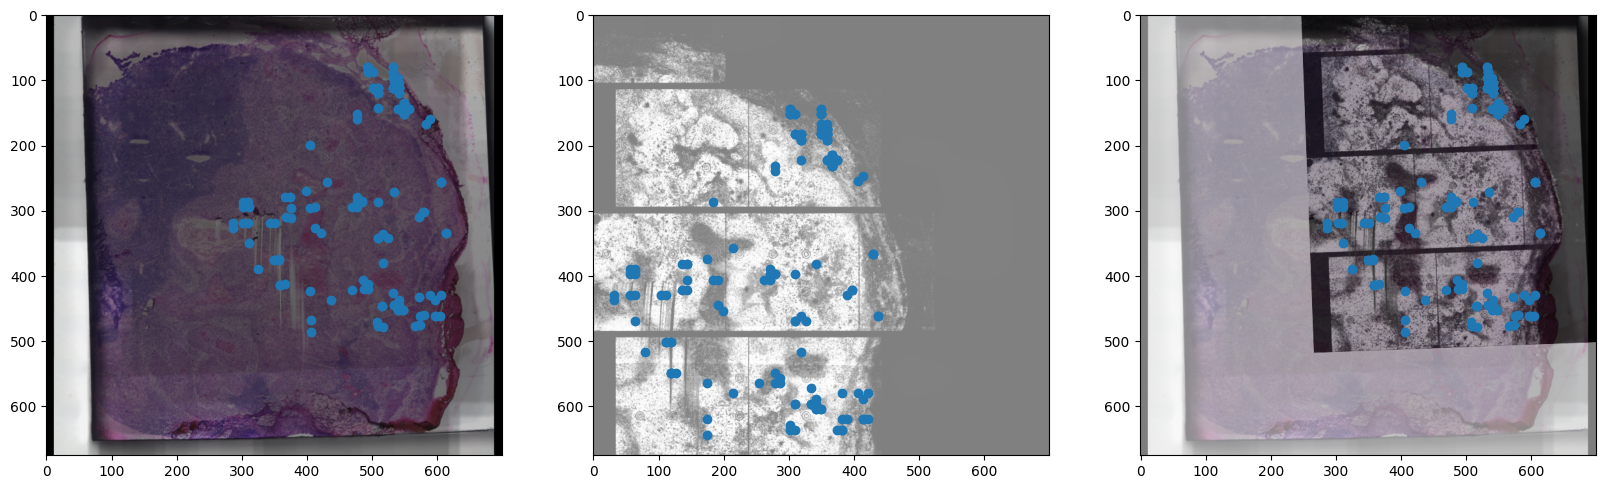

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(20, 20))
axes[0].imshow(transform_image(src.astype(np.uint8), _best_flip, [0, None, 0, None], _best_rotation))
axes[1].imshow(dst[0], cmap='Greys', alpha=0.5)
axes[1].scatter(in_mkpts0[:, 0], in_mkpts0[:, 1])
axes[0].scatter(in_mkpts1[:, 0], in_mkpts1[:, 1])

axes[2].imshow(transform_image(src.astype(np.uint8), _best_flip, [0, None, 0, None], _best_rotation))
axes[2].imshow(warp(dst[0], tform_points.inverse), cmap='Greys', alpha=0.5)
axes[2].scatter(in_mkpts1[:, 0], in_mkpts1[:, 1])
plt.show()

Fine registration with [-1, -1] flip and 90 rotation
Registering tile 0 with 5781407 coordinates


/home/dleonpe/miniconda3/envs/openst_dev/lib/python3.10/site-packages/skimage/util/dtype.py:492: UserWarning: Downcasting int64 to uint16 without scaling because max value 9 fits in uint16
  return _convert(image, np.uint16, force_copy)


Finding matches


/home/dleonpe/miniconda3/envs/openst_dev/lib/python3.10/site-packages/skimage/util/dtype.py:492: UserWarning: Downcasting int64 to uint16 without scaling because max value 255 fits in uint16
  return _convert(image, np.uint16, force_copy)
/home/dleonpe/miniconda3/envs/openst_dev/lib/python3.10/site-packages/skimage/util/dtype.py:492: UserWarning: Downcasting int64 to uint16 without scaling because max value 166 fits in uint16
  return _convert(image, np.uint16, force_copy)
/home/dleonpe/miniconda3/envs/openst_dev/lib/python3.10/site-packages/skimage/util/dtype.py:492: UserWarning: Downcasting int64 to uint16 without scaling because max value 163 fits in uint16
  return _convert(image, np.uint16, force_copy)
/home/dleonpe/miniconda3/envs/openst_dev/lib/python3.10/site-packages/skimage/util/dtype.py:492: UserWarning: Downcasting int64 to uint16 without scaling because max value 232 fits in uint16
  return _convert(image, np.uint16, force_copy)
/home/dleonpe/miniconda3/envs/openst_dev/lib

109 matches


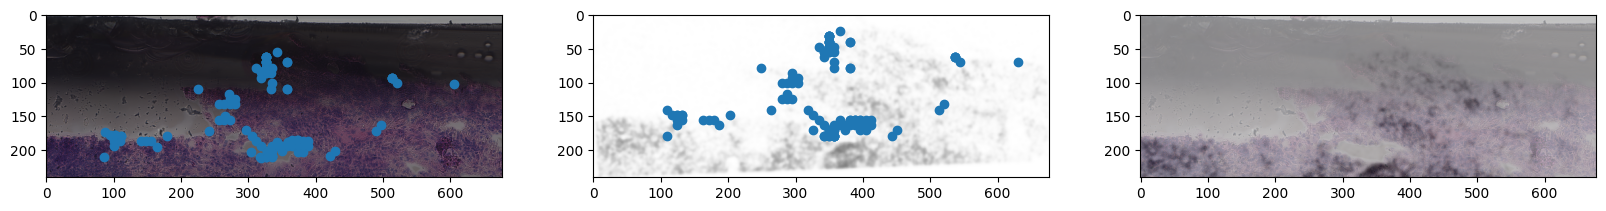

Registering tile 1 with 5781407 coordinates


/home/dleonpe/miniconda3/envs/openst_dev/lib/python3.10/site-packages/skimage/util/dtype.py:492: UserWarning: Downcasting int64 to uint16 without scaling because max value 12 fits in uint16
  return _convert(image, np.uint16, force_copy)


Finding matches


In [17]:
# STAGE 2: fine registration per tile
print(f"Fine registration with {_best_flip} flip and {_best_rotation} rotation")

# Collect tile identifiers
tile_codes = np.unique(puck_id.codes)

# Apply scaling to input image again, for fine registration
staining_image_rescaled = rescale(staining_image, 1/args.rescale_factor_fine, preserve_range=True, anti_aliasing=True, channel_axis=-1).astype(np.uint8)
src = staining_image_rescaled.astype(np.uint8)
src = transform_image(staining_image_rescaled, _best_flip, None, _best_rotation)

for tile_code in tile_codes:
    # Create a pseudoimage
    _t_puck_id = np.isin(puck_id.codes, tile_code)
    _t_valid_coords = np.isin(puck_id[(total_counts > args.threshold_counts_coarse)].codes[_i_sts_coords_coarse_within_image_bounds],tile_code)

    print(f"Registering tile {tile_code} with {len(_t_valid_coords)} coordinates")

    _t_sts_pseudoimage = create_pseudoimage(
        sts_coords_transformed[:, ::-1],  # we need to flip these coordinates
        args.pseudoimage_size_fine,
        staining_image_rescaled.shape,
        _t_valid_coords,
        recenter=False,
        rescale=True,
        values=None
    )

    _t_counts = total_counts[(total_counts > args.threshold_counts_coarse)][_i_sts_coords_coarse_within_image_bounds][_t_valid_coords]

    _t_sts_pseudoimage_counts = create_pseudoimage(
        sts_coords_transformed[:, ::-1],  # we need to flip these coordinates
        args.pseudoimage_size_fine,
        staining_image_rescaled.shape,
        _t_valid_coords,
        recenter=False,
        rescale=True,
        values=_t_counts
    )

    # Axis limits to crop both modalities to tile region
    _t_sts_coords_to_transform = _t_sts_pseudoimage["coords_rescaled"] * _t_sts_pseudoimage["rescaling_factor"]

    min_lim, max_lim = _t_sts_coords_to_transform[_t_valid_coords].min(axis=0).astype(
        int
    ), _t_sts_coords_to_transform[_t_valid_coords].max(axis=0).astype(int)
    x_min, y_min = min_lim
    x_max, y_max = max_lim

    # Preparing image and pseudoimage modalities for feature detection (imaging modality has optimal flip)
    def src_preprocessor(x, flip, rotation):
        return prepare_image_for_feature_matching(
            image=x,
            gaussian_blur=args.fine_registration_gaussian_sigma,
            crop=[x_min, x_max, y_min, y_max],
            mask_tissue=args.mask_tissue,
            keep_black_background=args.keep_black_background,
            mask_gaussian_blur=args.tissue_masking_gaussian_sigma,
        )

    dst = []
    for pseudoimage, invert in product([_t_sts_pseudoimage['pseudoimage'], _t_sts_pseudoimage_counts['pseudoimage'].astype(int)], [False, True]):
        dst += prepare_pseudoimage_for_feature_matching(
            pseudoimage[x_min:x_max, y_min:y_max],
            gaussian_blur=args.fine_registration_gaussian_sigma,
            invert=invert
        )

    print("Finding matches")
    # Finding matches between modalities
    _t_mkpts0, _t_mkpts1, _, _ = feature_matching.match_images(
        src,
        dst,
        flips=[_best_flip],
        rotations=[_best_rotation],
        src_augmenter=src_preprocessor,
        ransac_enabled=True,
        prefilter=False,
        ransac_min_samples=args.ransac_fine_min_samples,
        ransac_residual_threshold=args.ransac_fine_residual_threshold,
        ransac_max_trials=args.ransac_fine_max_trials,
        device='cuda'
    )
    print(f"{len(_t_mkpts0)} matches")

    # Compute similarity matrix and compute point transformation
    _t_tform_points = estimate_transform("similarity", _t_mkpts0, _t_mkpts1)

    fig, axes = plt.subplots(1, 3, figsize=(20, 20))
    dst_plot = transform_image(src, None, [x_min, x_max, y_min, y_max], None)
    axes[0].imshow(dst_plot)
    axes[1].imshow(dst[0], cmap='Greys', alpha=0.5)
    axes[1].scatter(_t_mkpts0[:, 0], _t_mkpts0[:, 1])
    axes[0].scatter(_t_mkpts1[:, 0], _t_mkpts1[:, 1])

    axes[2].imshow(dst_plot)
    axes[2].imshow(warp(dst[0], _t_tform_points.inverse), cmap='Greys', alpha=0.5)
    plt.show()

    # Apply the same transformation to the tiles
    _t_sts_coords_fine_to_transform = sts_coords_coarse[_t_puck_id] / args.rescale_factor_fine
    _t_sts_coords_fine_to_transform = (_t_sts_coords_fine_to_transform - np.array([[y_min, x_min]]))[:, ::-1]

    _t_sts_coords_fine_transformed = apply_transform(
        _t_sts_coords_fine_to_transform, _t_tform_points, check_bounds=True
    )

    # Rescale points to original HE dimensions
    _t_sts_coords_fine_transformed = _t_sts_coords_fine_transformed[:, :-1] + np.array([[y_min, x_min]])
    _t_sts_coords_fine_transformed = _t_sts_coords_fine_transformed * args.rescale_factor_fine

    out_coords_output_fine[_t_puck_id] = _t_sts_coords_fine_transformed

    # Saving alignment results here (only when passed)
    _align_result = AlignmentResult(
        name=f"fine_alignment_tile_{tile_code}",
        im_0=src,
        im_1=sts_pseudoimage["pseudoimage"],
        transformation_matrix=tform_points.params,
        ransac_results=None,
        sift_results=None,
        keypoints0=in_mkpts0,
        keypoints1=in_mkpts1,
    )
    metadata.add_alignment_result(_align_result)

In [14]:
sts_aligned_coarse, sts_aligned_fine, staining_image_aligned, metadata =  (
        out_coords_output_coarse,
        out_coords_output_fine,
        transform_image(staining_image, _best_flip, None, _best_rotation).astype(np.uint8),
        metadata,
    )

                         Hint: for large images, write a BaseMetadata.render method.
                               You can store compressed images as base64 strings. 
                               Other large datasets must not be stored as plain text.
                         Hint: for large images, write a BaseMetadata.render method.
                               You can store compressed images as base64 strings. 
                               Other large datasets must not be stored as plain text.
                         Hint: for large images, write a BaseMetadata.render method.
                               You can store compressed images as base64 strings. 
                               Other large datasets must not be stored as plain text.
                         Hint: for large images, write a BaseMetadata.render method.
                               You can store compressed images as base64 strings. 
                               Other large datasets must not be stored

Loading /data/rajewsky/home/dleonpe/projects/openst_paper/data/2_downstream/fc_sts_63/stitched/fc_sts_063_7_stitched_spots.h5ad
Writing output to /data/rajewsky/home/dleonpe/projects/openst_paper/data/2_downstream/fc_sts_63/auto_aligned_he/fc_sts_063_7_stitched_spots_aligned.h5ad
Output /data/rajewsky/home/dleonpe/projects/openst_paper/data/2_downstream/fc_sts_63/auto_aligned_he/fc_sts_063_7_stitched_spots_aligned.h5ad file was written


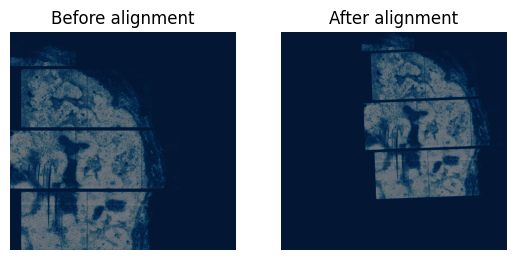

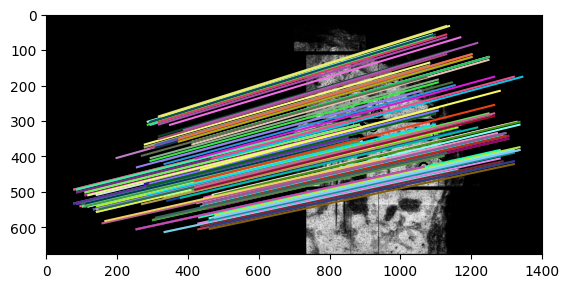

In [15]:
# Saving the metadata (for QC)
if args.metadata_out != "":
    metadata.render()
    metadata.save_json(args.metadata_out)

# Exporting the data
print(f"Loading {args.h5_in}")
adata = read_h5ad(args.h5_in)
adata.obsm["spatial_pairwise_aligned_coarse"] = sts_aligned_coarse
if sts_aligned_fine is not None:
    adata.obsm["spatial_pairwise_aligned_fine"] = sts_aligned_fine

if args.save_image_in_h5:
    adata.uns["spatial_pairwise_aligned"] = {}
    adata.uns["spatial_pairwise_aligned"]["staining_image"] = staining_image
    adata.uns["spatial_pairwise_aligned"]["staining_image_transformed"] = staining_image_aligned

print(f"Writing output to {args.h5_out}")
adata.write(args.h5_out)
print(f"Output {args.h5_out} file was written")